# Predator-Prey Population Dynamics: 
## The Lotka-Volterra model in Stan

- Author: Alexander Noll
- June 01 2019

In this notebook, we extend the [case study [1]](https://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html#exercises-and-extensions) on predator-prey population dynamics.

# Summary

We start with a short summary of [1]. We want to model the population dynamics of

+ a predator population and 
+ a prey population.

[1] focused on the case where the predators were the Canadian lynx and the prey were snowshoe hare. The data was collected from 1900 to 1920. 

Intuitively, one can imagine that we observe the following temporal pattern:

1. The prey population grows and the predator population is relatively small.
2. Having a lot of prey, predators can survive easier. This leads to growth of the predator population and decline in prey population.
3. The high number of predators have little prey available and thus the predator population declines. This leads us back to 1.

We can formalize this intuition in a pair of coupled, non-linear ordinary differential equations. Let $u(t) \geq 0$ and $v(t) \geq 0$ denote the prey- and predator population at time $t$, respectively. Then

$$
\frac{du(t)}{dt} = \alpha u(t) - \beta u(t)v(t), \\
\frac{dv(t)}{dt} = - \gamma v(t) + \delta u(t) v(t), \\
\alpha, \beta, \gamma, \delta \geq 0 \:.
$$

We can interpret the coefficients as follows:

+ $\alpha$ is the (relative) *growth rate* of the prey population in the absence of predators.
+ $\gamma$ is the (relative) *decline rate* of the predator population in the absence of prey.
+ The additional decline in prey population is proportional to the number of predators, with $\beta$ the constant of proportionality.
+ The growth in predator population is proportional to the prey population. $\delta$ gives the strength.

It's [well known](https://en.wikipedia.org/wiki/Lotka–Volterra_equations) that these equations, known as the Lotka-Volterra equations, have *periodic solutions*. 

## Data summary

Next, we will summarize the data, which we assume to be present in the current working directory.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.misc
import seaborn as sns
import pystan
import xarray as xr

# Set colors
sns.set_palette("deep")

class Globals(object):
    colors = dict(zip(['Lynx', 'Hare'], sns.color_palette("deep", 2)))
    
def prep_stan_data(df):
    """Helper function to prepare data to be fed into Stan model.
    
    Args:
      df: dataframe with columns 'Hare' and 'Lynx'.
      
    Returns:
      list of data to feed into Stan model.
    """
    N = df.shape[0]
    
    return {
        'N': N - 1,
        'ts': np.arange(1, N),
        'y_init': [df.Hare.values[0], data.Lynx.values[0]],
        'y': np.array(df.loc[1:, ['Hare', 'Lynx']])
    }

In [2]:
def plot_phase_space(x, y, alpha=1, color='black'):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = x.values
        y = y.values
    
    plt.quiver(x[:-1], y[:-1],
               x[1:] - x[:-1],
               y[1:] - y[:-1],
               scale_units='xy', angles='xy', scale=1, alpha=alpha, color=color)

In [3]:
data = pd.read_csv("./data.csv",
                   comment="#")

data.rename(columns=lambda x: x.strip(), inplace=True)
data.head()

,Year,Lynx,Hare
0,1900,4.0,30.0
1,1901,6.1,47.2
2,1902,9.8,70.2
3,1903,35.2,77.4
4,1904,59.4,36.3


The data frame has three columns

1. the observation year `Year`
2. the `Lynx` population, in thousands, and 
3. the `Hare` population, also in thousands.

We visualize the time evolution of the two populations. 

The plot on the left shows the time evolution in **[phase space](https://en.wikipedia.org/wiki/Phase_space)**. Recall that *phase space* is the space of all possible configurations of the dynamical system under consideration. In our example, phase space can be identified with $\bf P = \mathbb R_+ \times \mathbb R_+$, since any point $(z_1, z_2) \in \bf P$ corresponds to a valid set of population pairs. The arrows in the plot indicate the direction of time (more precisely, we should actually plot the *mean* populations, as these are the quantities we obtain from solving the ODE).

We can see that the dynamical systems seems to follow a periodic pattern, which is a well known result for the Lokta-Volterra equations.

The plot on the right shows both the Hare and Lynx population as a function of time. In this plot, we see the periodicity as well. Furthermore, we can recognize that the Lynx population peaks after the Hare population, as explained above.

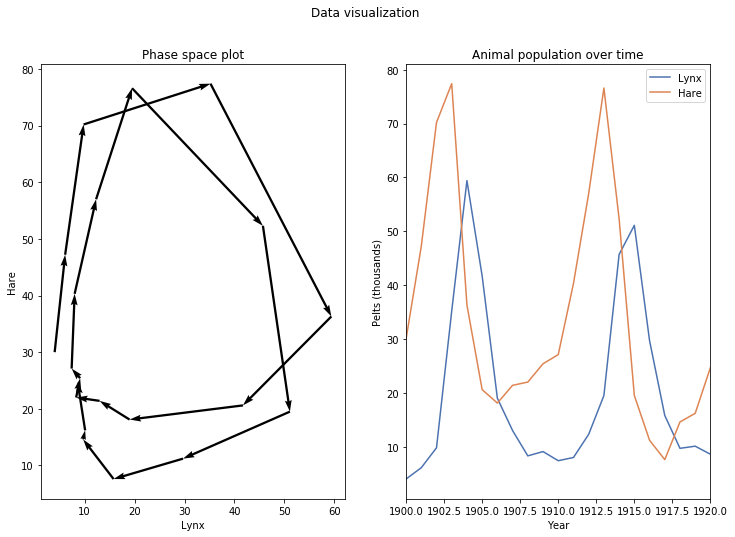

In [4]:
def plot_initial_data(df):
    # Bring data in long format
    plot_data = pd.melt(
        df, 
        id_vars='Year', 
        value_vars=['Lynx', 'Hare'], 
        var_name='Animal', value_name='pelts')

    
    # Initialize figure
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    f.suptitle("Data visualization")
    
    # Phase space plot
    ax1.quiver(data.Lynx[:-1].values, data.Hare[:-1].values, 
               data.Lynx[1:].values - data.Lynx[:-1].values, 
               data.Hare[1:].values - data.Hare[:-1].values, 
               scale_units='xy', angles='xy', scale=1,)

    ax1.set_title("Phase space plot")
    ax1.set_xlabel("Lynx")
    ax1.set_ylabel("Hare")

    # Time evolution of populations
    df.plot(ax=ax2, x='Year')

    ax2.set_title("Animal population over time")
    ax2.set_xlabel("Year")
    ax2.set_ylabel("Pelts (thousands)")
    
plot_initial_data(data)

Next, we fit the model from the original case study. The only thing we modified here is to put the definition of the ODE into a seaparte Stan file (`~/ode.stan`), as this function will be shared across models.

In [5]:
model_orig = pystan.StanModel("model.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cf5b981d41613c1770e4913adb2b2c86 NOW.


When we fit the model, we have to make sure that we delete the initial conditions from the data matrix `y`.

In [6]:
stan_data = prep_stan_data(data)
fit_orig = model_orig.sampling(data=stan_data, iter=2000, chains=4, seed=123)

After fitting we show a quick summary of the results:

+ There were no divergences during the fit. 
+ Also the R-hat statistics are close to one.
+ The `theta` parameters are the parameters of the ODE. 
+ `z_init` are the fitted initial means. 
+ `sigma` are the standard deviations in the lognormal distribution and 
+ `z` are the fitted mean population parameters.

In [7]:
fit_orig


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_cf5b981d41613c1770e4913adb2b2c86.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]              0.55  2.1e-3   0.06   0.43    0.5   0.54   0.59   0.69    977    1.0
theta[2]              0.03  1.3e-4 4.3e-3   0.02   0.02   0.03   0.03   0.04   1083    1.0
theta[3]               0.8  3.0e-3   0.09   0.64   0.74    0.8   0.86    1.0    927    1.0
theta[4]              0.02  1.1e-4 3.6e-3   0.02   0.02   0.02   0.03   0.03    999    1.0
z_init[1]            33.95    0.06    2.9  28.53  31.95  33.86  35.77  40.04   2050    1.0
z_init[2]             5.94    0.01   0.54   4.96   5.57   5.92   6.28   7.11   1765    1.0
sigma[1]              0.25  8.9e-4   0.04   0.18   0.22   0.24   0.27   0.36   2470    1.0
sigma[2]              0.25  8.8e-4   0.04  

The [rank plots](https://arxiv.org/abs/1903.08008) for the ODE parameters and the variance look close to uniform across chains for all paramteres, indicating a good mixing.

In [8]:
posterior = az.from_pystan(
    fit_orig, 
    posterior_predictive='y_rep',
    coords={'theta_dim_0': [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']})

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11c7944a8>,
      dtype=object)

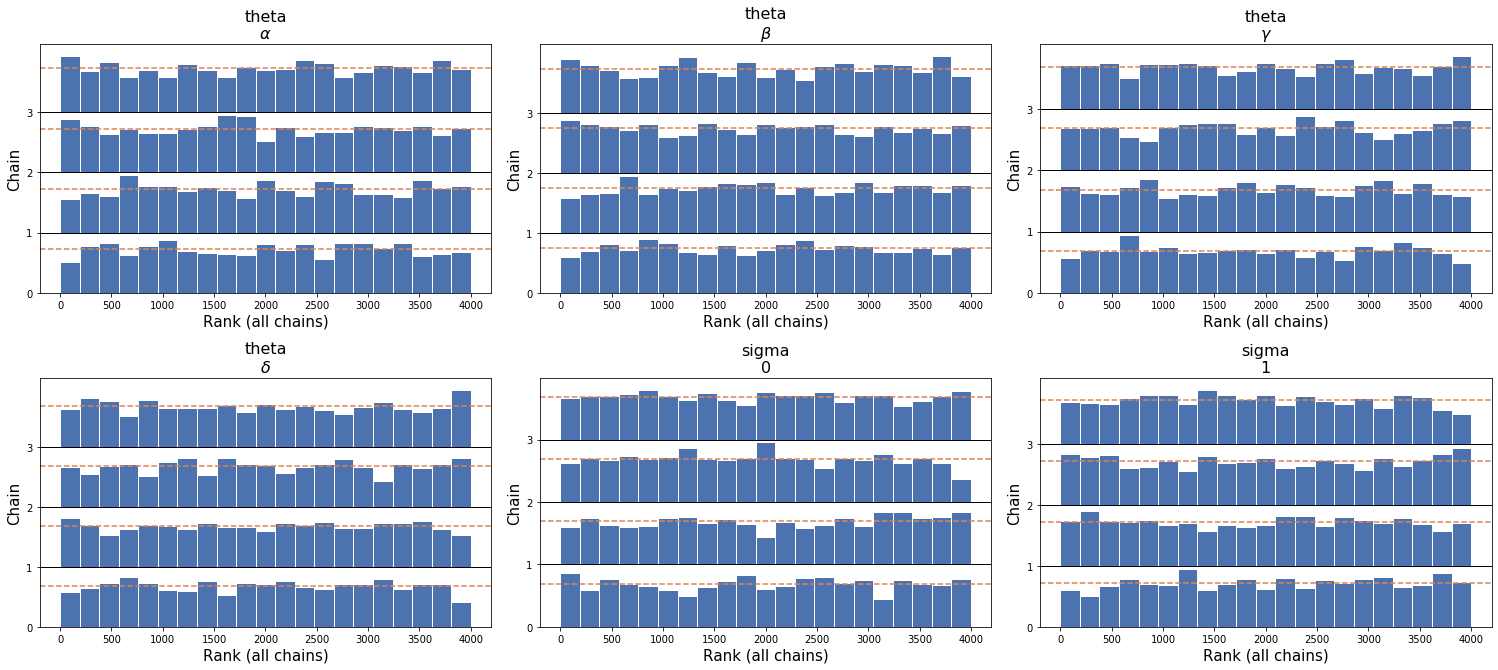

In [9]:
az.plot_rank(posterior, var_names=['theta', 'sigma'])

# Simulation-based calibration

## Description
We now turn to [validating the model fitting process](https://amstat.tandfonline.com/doi/abs/10.1198/106186006X136976). 
The main idea of the paper is based on the following simple observation: sampling a point from the joint distribution $p(y, \theta) \propto p(\theta)p(y\vert \theta)$ and performing inference to obtain points from $p(\theta \vert y)$ is the same as sampling directly from the prior $p(\theta)$, if the inference algorithm works correctly.

This implies that the quantile of a sample $\theta^0$ from the prior parameters should be *uniformly* distributed among the quantiles of the posterior $p(\theta \vert y)$, where $y$ is simulated using $\theta^0$. This observation leads to the following algorithm:

> **Algorithm 1**
>
>Repeat N times
>  1. Sample $\theta^0$ from $p(\theta)$
>  2. Sample observerations $y$ from $p(y \vert \theta^0)$
>  3. Calculate $L$ samples $\theta^1, \dots, \theta^L$ from the posterior $p(\theta \vert y)$
>  4. Compute the empirical quantile $q(\theta^0)$ of $\theta^0$ among the posterior samples $\theta^1,\dots,\theta^L$.
>
> Return length N array of quantiles.
  
We can then evaluate the uniformity by plotting a histogram of the ranks. In the algorithm above, we implicitly assumed that $\theta$ is a draw from the full prior distribution, i.e. $\theta$ is a point in the parameter space. We compute the empirical quantiles for the scalar components and make histograms for each component.

## A single iteration

We first carry out this procedure a single time, i.e. $N=1$ in the algorithm above.

We sample the prior parameters in Python, rather than Stan, but then pass the sampled parameters in the `data` block to Stan. This allows us to use Stan for integrating the ODE.

Note that the equation defining the ODE is shared between the model in the previous section and the model in this section. It is imported in both Stan files with an `#include "ode.stan";` statement in the `functions` block.

We show the model code below:

In [10]:
with open('fake_data_sampling.stan') as model_file:
    print(model_file.read())

functions {
#include "ode.stan";
}

data {
  int<lower=0> N;           // number of measurement times
  real ts[N];               // measurement times > 0
  real z_init[2];           // initial measured populations
  real<lower=0> theta[4];   // { alpha, beta, gamma, delta}
  real<lower=0> sigma[2];   // measurement errors
}

transformed parameters {
  real z[N, 2]
    = integrate_ode_rk45(dz_dt, z_init, 0, ts, theta,
                         rep_array(0.0, 0), rep_array(0, 0),
                         1e-5, 1e-3, 5e2);
}

generated quantities {
  real<lower=0> y_init[2];
  real<lower=0> y[N, 2];
  for (k in 1:2) {
    y_init[k] = lognormal_rng(log(z_init[k]), sigma[k]);
    y[ , k] = lognormal_rng(log(z[ , k]), sigma[k]);
  }
}


In [11]:
prior_sampler = pystan.StanModel("fake_data_sampling.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3df0cc286f55f4f3d25a1a26ae1372e3 NOW.


In [12]:
np.random.seed(2)
thetas = np.zeros(4)
# Taking the absolute value of a normal is the same as restricting the
# sampling from a normal with lower bound zero. 
thetas[[0, 2]] = np.abs(np.random.normal(1, 0.5, size=2))
thetas[[1, 3]] = np.abs(np.random.normal(0.05, 0.05, size=2))

# Sample variances
sigmas = np.random.lognormal(-1, 1, size=2)

# Sample initial means
z_init = np.random.lognormal(np.log(10), 1, size=2)

# Compose into data to pass to stan
gen_data = {
    'N': data.shape[0] - 1,
    'ts': np.arange(1, data.shape[0]),
    'z_init': z_init,
    'theta': thetas,
    'sigma': sigmas}

# Integrate the ODE and sample from the log normal
gen_data = prior_sampler.sampling(
    gen_data,
    algorithm='Fixed_param',
    warmup=0,
    iter=1)

We use [arviz](https://arviz-devs.github.io/arviz/) to extract the sampled data. Then we repeat the phase space plot from the beginning.

/Users/Alex/.local/share/virtualenvs/StanCS-04kPSO1L/lib/python3.7/site-packages/arviz/data/base.py:123: SyntaxWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
  SyntaxWarning,


Text(0, 0.5, 'Pelts (thousands)')

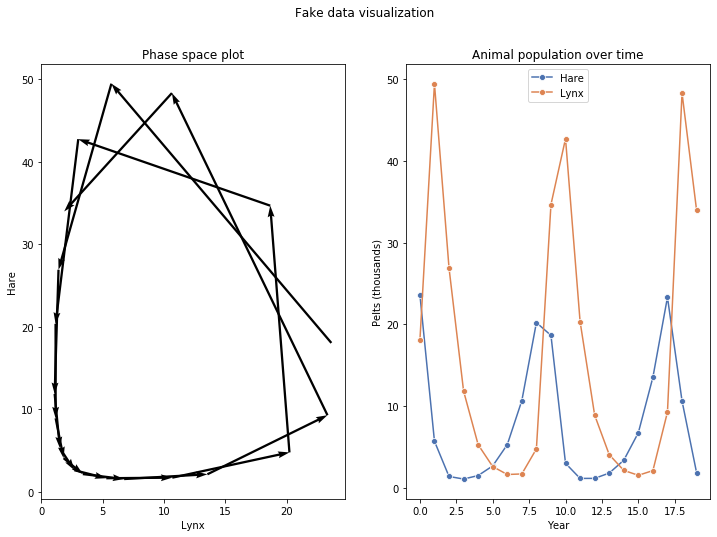

In [13]:
z_ = az.from_pystan(gen_data).posterior['z']

# Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

f.suptitle("Fake data visualization")

ax1.quiver(z_.data[0, 0, :-1, 0], z_.data[0, 0, :-1, 1], 
           z_.data[0, 0, 1:, 0] - z_.data[0, 0, :-1, 0], 
           z_.data[0, 0, 1:, 1] - z_.data[0, 0, :-1, 1], 
           scale_units='xy', angles='xy', scale=1,)

ax1.set_title("Phase space plot")
ax1.set_xlabel("Lynx")
ax1.set_ylabel("Hare")

sns.lineplot(x=np.arange(0, 20), y=z_.data[0, 0, :, 0], label='Hare', marker='o', ax=ax2)
sns.lineplot(x=np.arange(0, 20), y=z_.data[0, 0, :, 1], label='Lynx', marker='o', ax=ax2)

ax2.set_title("Animal population over time")
ax2.set_xlabel("Year")
ax2.set_ylabel("Pelts (thousands)")

**EXPLAIN WHY WE PLOT**
The goal of this exercise is not to do a prior-predictive check, but rather to ensure that the model fitting process works well. Nevertheless, it makes sense to ensure that the simulated data are not too far the expected values, as the model fitting process may fail because of data that are on the wrong scale. **WHY?**

Our next goal is to perform step 3. from Algorithm 1, i.e. perform MCMC on the simulated data. We can use the original Stan model for this task.

In [14]:
# Extract fake *data*
post = az.from_pystan(gen_data).posterior
# Put them into format for Stan
stan_data = {
    'N': data.shape[0] - 1,
    'ts': np.arange(1, data.shape[0]),
    'y_init': post['y_init'][0, 0, :],
    'y': post['y'][0, 0, :, :]  # Don't need to subindex from 0
    }

# and sample
gen_fit = model_orig.sampling(data=stan_data, iter=1000, chains=4, seed=123)

Let's compare the true values $\theta^0$ to the fitted. The right most column shows the main quantity of interest: the quantile of $\theta^0$ among the MCMC posterior samples. As we mentioned before, if the inference algorithm works correctly, this quantity should be distributed uniformly.

In [15]:
posterior = az.from_pystan(
    gen_fit, 
    posterior_predictive='y_rep')

theta_post = posterior.posterior['theta'].stack(sample=('chain', 'draw')).values
with_exact = np.concatenate([np.reshape(thetas, (4, 1)), theta_post], axis=1)
theta_qs = with_exact.argsort(axis=1)[:, 0] / with_exact.shape[1]

sigma_post = posterior.posterior['sigma'].stack(sample=('chain', 'draw')).values
with_exact = np.concatenate([np.reshape(sigmas, (2, 1)), sigma_post], axis=1)
sigma_qs = with_exact.argsort(axis=1)[:, 0] / with_exact.shape[1]

z_init_post = posterior.posterior['z_init'].stack(sample=('chain', 'draw')).values
with_exact = np.concatenate([np.reshape(z_init, (2, 1)), z_init_post], axis=1)
z_init_qs = with_exact.argsort(axis=1)[:, 0] / with_exact.shape[1]


sigma_qs

array([0.84457771, 0.65817091])

In [16]:
summary = az.summary(
    gen_fit,
    var_names=['theta', 'sigma', 'z_init'])
summary['true_value'] = [round(val, 2) for ar in [thetas, sigmas, z_init] for val in ar]
summary['quantile'] = np.round(np.concatenate([theta_qs, sigma_qs, z_init_qs]), 2)
summary

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,true_value,quantile
theta[0],0.832,0.019,0.001,0.001,0.797,0.869,593.0,593.0,592.0,781.0,1.01,0.79,0.03
theta[1],0.064,0.004,0.000,0.000,0.055,0.072,758.0,758.0,748.0,962.0,1.01,0.06,0.03
theta[2],0.905,0.028,0.001,0.001,0.856,0.959,616.0,615.0,618.0,863.0,1.01,0.97,0.81
theta[3],0.120,0.004,0.000,0.000,0.112,0.128,594.0,592.0,598.0,803.0,1.01,0.13,0.81
sigma[0],0.044,0.009,0.000,0.000,0.029,0.060,1126.0,1071.0,1208.0,1003.0,1.00,0.06,0.84
sigma[1],0.222,0.038,0.001,0.001,0.156,0.293,1322.0,1270.0,1399.0,938.0,1.00,0.16,0.66
z_init[0],17.628,0.364,0.011,0.008,16.968,18.326,1024.0,1024.0,1021.0,990.0,1.01,16.53,0.36
z_init[1],3.227,0.200,0.005,0.004,2.851,3.599,1334.0,1324.0,1342.0,1306.0,1.01,2.88,0.83


We see that no quantiles are very extreme and that we can recover the parameters well.

## Multiple draws

With a single iteration, we cannot check the distribution of the quantiles of $\theta^0$ among the MCMC samples. To check uniformity of the quantile, we thus need to repeat the above procedure multiple times. Here, we take 50 repetitions.

This means that we sample 50 fake data sets, integrate the ODE and add lognormally distributed noise. Then we fit the posterior distribution and calculate the quantile of the parameter $\theta^0$.

In [ ]:
def get_fake_data(seed=None):
    """
    Simulate a dataset from the full model p(y, theta).
    
    Args:
      seed: The random seed to simulate data
      
    Returns:
      (theta, sigmas, z_init, fake_data): Parameters used to simulate fake_data and
        the simulated data.
    """
    if seed:
        np.random.seed(seed)
        
    thetas = np.zeros(4)
    # Taking the absolute value of a normal is the same as restricting the
    # sampling from a normal with lower bound zero. 
    thetas[[0, 2]] = np.abs(np.random.normal(1, 0.5, size=2))
    thetas[[1, 3]] = np.abs(np.random.normal(0.05, 0.05, size=2))

    sigmas = np.random.lognormal(-1, 1, size=2)

    z_init = np.random.lognormal(np.log(10), 1, size=2)

    fake_sampler_data = {'N': data.shape[0] - 1,
                         'ts': np.arange(1, data.shape[0]),
                         'z_init': z_init,
                         'theta': thetas,
                         'sigma': sigmas}

    fake_data = fake_sampler.sampling(fake_sampler_data, algorithm='Fixed_param', warmup=0, iter=1)
    
    return thetas, sigmas, z_init, fake_data

def fit_model(sim_data):
    """
    Use Stan to fit the Volterra Lotka equations to dataset.
    
    Args:
      sim_data: data set which should be fitted
      
    Returns:
      fitted object returned by Stan
    """

    # Put them into format for Stan
    stan_data = {'N': data.shape[0] - 1,
                 'ts': np.arange(1, data.shape[0]),
                 'y_init': sim_data['y_init'][0, 0, :],
                 'y': sim_data['y'][0, 0, :, :]  # Don't need to subindex from 0
                 }

    # and sample
    fit = model.sampling(data=stan_data, iter=1000, chains=4)
    
    return fit

def calc_qs(thetas, sigmas, z_init, fit):
    """
    Calculate posterior quantiles of prior parameters.
    
    Args:
      thetas, sigmas, z_init: Parameters used to simulate data.
      fit: object fitted to data generated with above parameters.
      
    Returns:
      Quantile of prior parameters in posterior distribution of fit.
    """
    posterior = az.from_pystan(
    fit, 
    posterior_predictive='y_rep')

    theta_post = posterior.posterior['theta'].stack(sample=('chain', 'draw')).values
    with_exact = np.concatenate([np.reshape(thetas, (4, 1)), theta_post], axis=1)
    theta_qs = with_exact.argsort(axis=1)[:, 0] / with_exact.shape[1]

    sigma_post = posterior.posterior['sigma'].stack(sample=('chain', 'draw')).values
    with_exact = np.concatenate([np.reshape(sigmas, (2, 1)), sigma_post], axis=1)
    sigma_qs = with_exact.argsort(axis=1)[:, 0] / with_exact.shape[1]

    z_init_post = posterior.posterior['z_init'].stack(sample=('chain', 'draw')).values
    with_exact = np.concatenate([np.reshape(z_init, (2, 1)), z_init_post], axis=1)
    z_init_qs = with_exact.argsort(axis=1)[:, 0] / with_exact.shape[1]


    return np.concatenate([theta_qs, sigma_qs, z_init_qs])

def val_fit(N=20):
    """
    Entire model validation procedure.
    
    Args:
      N: number of quantiles
      
    Returns:
      numpy array of prior quantiles in posterior distribution.
    """
    quantiles = np.zeros((N, 8))
    
    i = 0
    while i < N:
        try:
            thetas, sigmas, z_init, sim_data = get_fake_data()

            # Extract fake *data*
            post = az.from_pystan(sim_data).posterior

            fit = fit_model(post)

            quantiles[i, :] = calc_qs(thetas, sigmas, z_init, fit)
            
            i += 1
        except:
            pass
    
    return quantiles

fitted_qs = val_fit(50)

The plot below shows the quantile distribution by parameter. Due to the small size of only 50 quantiles, it's not entirely clear that all quantiles follow a $\mathcal U(0, 1)$ distribution, but there's certainly no strong contraindication. Thus, we conclude that the model fitting process works reasonably well.

In [ ]:
fitted_xr = xr.DataArray(
    fitted_qs,
    dims=['draw', 'var'],
    coords={'var': ['theta_1', 'theta_2', 'theta_3', 'theta_4', 'z_init_1', 'z_init_2', 'sigma_1', 'sigma_2'],
            'draw': np.arange(fitted_qs.shape[0])})

sns.FacetGrid(fitted_xr.to_pandas().melt(), col='var', col_wrap=4).\
  map(plt.hist, 'value')

# Forecasting and backcasting

In this section, our goal is to use the equations to forecast the predator- and prey populations 50 years into the future. We can do that by integrating the ODE determining the population averages further into the future.

We can most easily extend the `generated quantities` block in the model and add a `generated data` block. In the latter, we "calculate" the future time steps `t_pred`. In the former, weuse the Runge-Kutta integrator to make the forecast 50 time steps into the future.

The initial conditions for forecasting are the last entries `z[N, :]`. These are the mean values at the last timestep when we had data.

In [ ]:
with open('model_forecast.stan') as model_file:
    print(model_file.read())

We pass the model to Stan and extract the posterior using `arviz`. We concatenate the fitted population values and the predicted population values into a single numpy array `fit_post_concat`of length `data.shape[0] + N_pred = 70`. The reshaping essentially makes sure that we convert an array of shape `(4, 500, 70, 2)` to shape `(2000, 70, 2)`. The former dimensions correspond to `(chain, sample within chain, time, z_dim)`, while the latter contains the concatentated chains.

In [ ]:
model = pystan.StanModel("model_forecast.stan")

stan_data = {
    'N': data.shape[0] - 1,
    'ts': np.arange(1, data.shape[0]),
    'y_init': [data.Hare.values[0], data.Lynx.values[0]],
    'y': np.array(data.loc[1:, ['Hare', 'Lynx']]),
    'N_pred': 50
     }

fit = model.sampling(data=stan_data, iter=1000, chains=4, seed=123)

fit_post = az.from_pystan(fit).posterior
fit_post_concat = np.concatenate([fit_post.z.values, fit_post.z_pred.values], axis=2).reshape((-1, 70, 2))



Next, we sample `n_rep=9` samples from the posterior to qualitatively explore the beahviour of the solutions and use them to make phase space plots. The forecast points are colored red, while the fitted values are drawn in black. We see that the predictions look stable and follow very similar trajectories in the future.

In [ ]:
n_rep = 9
sampled = fit_post_concat[np.random.choice(2000, size=n_rep)]

f, ax = plt.subplots(3, 3, figsize=(12, 8))
f.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel("Lynx")
plt.ylabel("Hare")
plt.suptitle("Phase space plot")

for i in range(n_rep):
    plt.sca(ax.reshape(-1)[i])
    plot_phase_space(sampled[i, :20, 0], sampled[i, :20, 1], alpha=0.9)
    plot_phase_space(sampled[i, 20:, 0], sampled[i, 20:, 1], alpha=0.5, color='red')


We make another plot to show the behavior over time, rather than in phase space. We see that the "observed" behavior (which is fitted as well) continues in the future.

In [ ]:
f, ax = plt.subplots(3, 3, figsize=(12, 8))
f.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel("Time")
plt.ylabel("Population")
plt.suptitle("Prediction of population evolution")

for i in range(n_rep):
    plt.sca(ax.reshape(-1)[i])
    plt.plot(np.arange(20), sampled[i, :20, 0])
    plt.plot(np.arange(20, 70), sampled[i, 20:, 0], color='#4c72b0', linestyle=':')
    plt.plot(np.arange(20), sampled[i, :20, 1])
    plt.plot(np.arange(20, 70), sampled[i, 20:, 1], color='#dd8452', linestyle=':')


We make a similar "aggregated" plot, where we show multiple posterior samples in a single axis. This has the advantage of showing the distributions of both animal populations. Of course, the individual trajectories belonging together can't be identified anymore. The thickened line is the posterior mean prediction.

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
f.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel("Time")
plt.ylabel("Animal population")
plt.suptitle("Prediction of population evolution")

for i in range(100):
    plt.plot(np.arange(20), fit_post_concat[i, :20, 0], color='#4c72b0', alpha=0.2)
    plt.plot(np.arange(19, 70), fit_post_concat[i, 19:, 0], color='#4c72b0', linestyle=':', alpha=0.2)
    plt.plot(np.arange(20), fit_post_concat[i, :20, 1], color='#dd8452', alpha=0.2)
    plt.plot(np.arange(19, 70), fit_post_concat[i, 19:, 1], color='#dd8452', linestyle=':', alpha=0.2)

plt.plot(np.arange(70), fit_post_concat.mean(axis=0)[:, 0], label='Hare')
plt.plot(np.arange(70), fit_post_concat.mean(axis=0)[:, 1], label='Lynx')
plt.legend()

## Predicting the past

Solving for times in the past can be done very easily in Stan. We simply reverse the vector field in the ODE. For this we write a function `dzdminust` which reversing the two outputs `du_dt` and `dv_dt`.

In [ ]:
with open('model_backcast.stan') as model_file:
    print(model_file.read())

In [ ]:
model = pystan.StanModel("model_backcast.stan")

stan_data = {
    'N': data.shape[0] - 1,
    'ts': np.arange(1, data.shape[0]),
    'y_init': [data.Hare.values[0], data.Lynx.values[0]],
    'y': np.array(data.loc[1:, ['Hare', 'Lynx']]),
    'N_pred': 50
    }

fit = model.sampling(data=stan_data, iter=1000, chains=4, seed=123)

The Markov chains mixed well:

In [ ]:
az.plot_rank(fit, var_names=['theta', 'z_init', 'sigma'])

In [ ]:
fit_post = az.from_pystan(fit).posterior
fit_post_concat = np.concatenate([fit_post.z_pred.values[:, :, ::-1, :], fit_post.z.values], axis=2).reshape((-1, 70, 2))

Now, we can plot various quantities again, such as the temporal evoulution of both (where lines belonging to the same posterior draw can't be identified). We just need to make sure that we now also reverse the time dimension.

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
# hide tick and tick label of the big axes
plt.xlabel("Time")
plt.ylabel("Animal population")
plt.suptitle("Pastdiction of population evolution")

for i in range(10):
    plt.plot(np.arange(-50, 0), fit_post_concat[i, :50, 0], color='#4c72b0', alpha=0.2)
    plt.plot(np.arange(0, 20), fit_post_concat[i, 50:, 0], color='#4c72b0', linestyle=':', alpha=0.2)
    plt.plot(np.arange(-50, 0), fit_post_concat[i, :50, 1], color='#dd8452', alpha=0.2)
    plt.plot(np.arange(0, 20), fit_post_concat[i, 50:, 1], color='#dd8452', linestyle=':', alpha=0.2)

plt.plot(np.arange(-50, 20), fit_post_concat.mean(axis=0)[:, 0], label='Hare')
plt.plot(np.arange(-50, 20), fit_post_concat.mean(axis=0)[:, 1], label='Lynx')
plt.legend()

In the plot above, we see that we can also make stable and reasonable "backcasts" of the data.

# Missing data

Our goal in this section is to understand the impact of *missing data* on the model fitting. See the [Stan manual](https://mc-stan.org/docs/2_20/stan-users-guide/missing-data.html) for an overview of how to deal with missing data in Stan.

This section is split in two parts:

1. Dealing with a single missing point.
2. Exploring what happens when more points are missing.

## A single missing point

We start by setting a single value, namely in 1905, of the Lynx population to missing.

In [ ]:
data_missing = data.copy()
data_missing.loc[lambda x: (x.Year == 1905), "Lynx"] = None
data_missing

Next, we will fit the original Stan model, but we modify the progam so that it can cope with missing data. The [relevant section from the Stan manual is 3.3](https://mc-stan.org/docs/2_20/stan-users-guide/sliced-missing-data.html). We will recode the data in long format, i.e. one row in the data is of the form `(year=tt, species=species, population=yy)`.

We make the assumption that the initial conditions for the ODE are non-missing.

The number of observations is called `J` and we encode the species `species[j]` associated with observation `j` as an integer. Furthermore, we have the observation time `tt[j]` and the observed population `yy[j]`.

To *impute* the missing observation, we specify the number of missing observations `J_mis` and the corresponding species `species_mis` and times `tt_mis`. Note that this step is *not necessary for fitting the model*. 

The `model` block is similar to the original one. The main change is that we have to look up the species, year and population associated with each observation `j` to plug it into the likelihood.

> Remark: For an ODE, once we specify the initial conditions and ODE parameters, we can use observations at arbitrary times to tighten the paramter estimates. In that sense, we don't really have missing values, we just have fewer observations.

In [ ]:
with open('missing_model.stan') as model_file:
    print(model_file.read())

In [ ]:
model_missing = pystan.StanModel("missing_model.stan")

Next, we bring our data frame with missing values into "long" or "melted" form. In pandas, we can do this with the `melt` function, specifying which column should serve as new id and which columns should be "put below each other". Furthermore, we specify the name of the new column.

To pass the data on to Stan, we also `factorize` the data, meaning that the species are converted from a string (Lynx and Hare) to respective indices (1 and 2). We also cast the year as an integer variable, called `Year_ind`, starting at 1.

In [ ]:
data_long = pd.melt(
    data_missing,
    id_vars=['Year'],
    value_vars=['Lynx', 'Hare'],
    var_name='Species'
).loc[lambda x: (x.value.notnull()) & (x.Year != 1900)]. \
    reset_index()

data_long['Year_ind'] = data_long['Year'] - data['Year'].min()
data_long['Species_ind'] = np.where(data_long.Species == "Hare", 1, 2)

data_long.head()

Also, we generate a dataframe with the missing values removed.

In [ ]:
data_mis = pd.melt(
    data_missing,
    id_vars=['Year'],
    value_vars=['Lynx', 'Hare'],
    var_name='Species'
).loc[lambda x: (x.value.isnull()) & (x.Year != 1900)]. \
    reset_index()

data_mis['Year_ind'] = data_mis['Year'] - data['Year'].min()
data_mis['Species_ind'] = np.where(data_mis.Species == "Hare", 1, 2)

We can now feed our input to Stan.

In [ ]:
stan_data = {
    'J': data_long.shape[0],
    'species': data_long.Species_ind.values,
    'tt': data_long.Year_ind.values,
    'yy': data_long.value.values,
    'N': data.shape[0] - 1,
    'ts': np.arange(1, data.shape[0]),
    'y_init': [data.Hare.values[0], data.Lynx.values[0]],
    'J_mis': data_mis.shape[0],
    'species_mis': data_mis.Species_ind.values,
    'tt_mis': data_mis.Year_ind.values
    }

fit = model_missing.sampling(
    data=stan_data, 
    iter=2000,
    chains=4,
    seed=123)

In [ ]:
fit_post = az.from_pystan(fit)

### Diagnostics

In [ ]:
fit

We have no divergences. Also, the Rhat values are all equal to one up to rounding errors. The rank plots, shown here for the missing values `y_mis` and the ODE parameters `theta` look reasonable. Note that while `y_mis` is not a parameter (it is a `generated quantity`), we can still use it to detect bad mixing of the chains, since `y_mis` depends directly on the posterior parameters.

In [ ]:
az.plot_rank(fit_post, var_names=['y_mis', 'theta'])

### Exploration

To see if the imputed values are reasonable, we plot randomly sampled trajectories of the animal populations and add the imputed values on top.

*Remarks*:
1. The imputed values correspond to the *observed* values, not to the mean population values. Thus, we expect a lot of variation in the imputed values.
2. The imputed mean value `z` interpolates smoothly between the data in 1904 and 1906.

In [ ]:
for i in range(40):
    sampled_chain = np.random.randint(4)
    sampled_draw = np.random.randint(1000)
    trajectory = fit_post.posterior['z'].loc[{'chain': sampled_chain, 'draw': sampled_draw}]

    plt.plot(
        data.Year[1:], 
        trajectory.loc[:, 0], 
        color=Globals.colors['Hare'], 
        alpha=.2,
        label='Hare' if i == 0 else None)
    
    plt.plot(
        data.Year[1:], 
        trajectory.loc[:, 1], 
        color=Globals.colors['Lynx'], 
        alpha=.2,
        label='Lynx' if i == 0 else None)
    
    plt.scatter(
        data_mis.Year, 
        fit_post.posterior['y_mis'].loc[{'chain': sampled_chain, 'draw': sampled_draw}], 
        color=Globals.colors['Lynx'],
        s=5)
    
plt.legend()

## More missing values

We randomly delete points from the `melt`ed dataset and then refit the model. The number of missing data points is $1, 6, 11, \dots, 36$. 

We then collect all posterior distributions in a common `xarray` object `all_post`. This `xarray` has an additional dimension, `n_mis` indicating the number of missing observarions. 

In [ ]:
# Convert all data to long format
data_long = pd.melt(
    data,
    id_vars=['Year'],
    value_vars=['Lynx', 'Hare'],
    var_name='Species'
).loc[lambda x: x.Year != 1900]. \
    reset_index()

# This is the sequence of values that will be encoded as missing
np.random.seed(0)
missing_seq = np.random.permutation(data_long.shape[0] - 1)

fits = []



for i in range(1, data_long.shape[0] - 1, 5):
    data_with_nan = data_long.copy()
    data_with_nan.loc[missing_seq[:i], 'value'] = None
    
    data_missing = data_with_nan. \
        copy(). \
        loc[lambda x: x.value.isnull()]. \
        reset_index()
    data_missing['Year_ind'] = data_missing['Year'] - data['Year'].min()
    data_missing['Species_ind'] = np.where(data_missing.Species == "Hare", 1, 2)
    
    data_to_fit = data_with_nan. \
        copy(). \
        loc[lambda x: (x.value.notnull())]. \
        reset_index()
    
    data_to_fit['Year_ind'] = data_to_fit['Year'] - data['Year'].min()
    data_to_fit['Species_ind'] = np.where(data_to_fit.Species == "Hare", 1, 2)

    stan_data = {
        'J': data_to_fit.shape[0],
        'species': data_to_fit.Species_ind.values,
        'tt': data_to_fit.Year_ind.values,
        'yy': data_to_fit.value.values,
        'N': data.shape[0] - 1,
        'ts': np.arange(1, data.shape[0]),
        'y_init': [data.Hare.values[0], data.Lynx.values[0]],
        'J_mis': data_missing.shape[0],
        'species_mis': data_missing.Species_ind.values,
        'tt_mis': data_missing.Year_ind.values
    }

    fit = model_missing.sampling(
        data=stan_data, 
        iter=2000,
        chains=4,
        seed=123)
    
    fits.append(fit)
    
all_post = xr.concat(
    [az.from_pystan(x).posterior for x in fits[0:]], 
    pd.Index(range(1, data_long.shape[0] - 1, 5), name='n_miss'))

all_post.coords['theta_dim_0'].values = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']

The plots below show the standard deviation of the marginal posterior distribution for selected parameters. The standard deviation increases with the number of missing points, as expected.

In [ ]:
all_post['theta'].std(['chain', 'draw']).plot(col='theta_dim_0')

In [ ]:
all_post['z_init'].std(['chain', 'draw']).plot(col='z_init_dim_0')

We can also look at the full distribution of the posterior parameters, rather than only the standard deviation. We see that the estimates stay relatively stable, even for a large number of missing values. Once we reach 36 missing values, however, the model becomes very uncertain about the posterior.

In [ ]:
all_post['theta']. \
    to_dataframe(). \
    reset_index(). \
    pipe(sns.FacetGrid, col='theta_dim_0', sharey=False). \
    map(sns.boxenplot, 'n_miss', 'theta')

In [ ]:
all_post['z_init']. \
    to_dataframe(). \
    reset_index(). \
    pipe(sns.FacetGrid, col='z_init_dim_0', sharey=False). \
    map(sns.boxenplot, 'n_miss', 'z_init')

Finally, we show the predicted mean trajectories as a functino of the number of missing data points. We make the following two observations:

1. The uncertainty of the predicted trajectory increases with the number of missing data points.
2. The estimates of the mean population stays relatively stable and senisble until we fit with 36 missing points. Note that in this case we have more parameters than data!

In [ ]:
all_post['z']. \
    to_dataframe(). \
    reset_index(). \
    loc[lambda x: x.draw < 100]. \
    pipe(sns.FacetGrid, col='n_miss', col_wrap=3). \
    map(sns.lineplot, 'z_dim_0', 'z', 'z_dim_1', ci='sd')

# Error model

We replace the error model from a *log-normal* with a *normal* model. This means that we sample

$$
y_{n, k} = z_{n, k} + \epsilon_{n, k} \\
\epsilon_{n, k} \sim \text{Normal}(0, \sigma) \:.
$$


*Remarks*:
+ The first graph in this notebook shows almost an order of magnitude difference in Lynx population between the its maximum and minimum. If the deviation of the observed population from the modelled population is somehow proportional to the population, then we have a big risk of giving negative populations a non-zero likelihood.
+ Intuitively, unexpected events (say, a drought), should reduce a certain proportion of the population, rather than a fixed amount.

Changing the model in Stan is very straightforward: we simply change the likelihood term from `lognormal` to `normal` and replace the `lognormal_rng` with a `normal_rng` in the `generated quantities` block.

In [ ]:
model = pystan.StanModel("model_normal.stan")

stan_data = {'N': data.shape[0] - 1,
             'ts': np.arange(1, data.shape[0]),
             'y_init': [data.Hare.values[0], data.Lynx.values[0]],
             'y': np.array(data.loc[1:, ['Hare', 'Lynx']])
             }

fit = model.sampling(data=stan_data, iter=2000, chains=4, seed=123)

In [ ]:
fit

The diagnostics look good: the Rhat values are close to one, the rank plots indicate good mixing and we see no divergences.

In [ ]:
az.plot_rank(fit, var_names=['theta', 'sigma'])

Let's now investigate the predictions of the mean, i.e. the `z` variable. We pick 100 posterior draws at random and plot the associated mean predictions.

In [ ]:
z_ = az.from_pystan(fit).posterior['z'].stack(i=('chain', 'draw'))

for i in range(100):
    plt.plot(np.arange(20), z_[:, 0, i], 
             color=Globals.colors['Hare'], 
             alpha=0.2, 
             label='Hare' if i == 0 else None)
    
    plt.plot(np.arange(20), z_[:, 1, i], 
             color=Globals.colors['Lynx'], 
             alpha=0.2,
             label='Lynx' if i == 0 else None)
    
plt.legend()

This does not look too unreasonable. All the means are positive and, at least for the Lynx population the fits are relatively tight. This does, however, not mean that we've ended up with a good model. We investigate the posterior data, i.e. the `y` variables. To get a feel for them, we simply randomly plot some.

In [ ]:
y_ = az.from_pystan(fit).posterior['y_rep']. \
    stack(i=('chain', 'draw')). \
    reset_index('i'). \
    assign_coords(y_rep_dim_1=['Hare', 'Lynx'])

fig, ax = plt.subplots(figsize=(20, 10))

z_.mean(dim='i').sel(z_dim_1=0).plot.line(color=Globals.colors['Hare'], label='Hare', linewidth=4.0)
z_.mean(dim='i').sel(z_dim_1=1).plot.line(color=Globals.colors['Lynx'], label='Lynx', linewidth=4.0)

for i in range(200):
    ind = np.random.randint(4000)
    posterior_sample = y_.sel(i=ind)
    posterior_sample.sel(y_rep_dim_1='Hare').plot(color='#4c72b0', alpha=0.2, ax=ax)
    posterior_sample.sel(y_rep_dim_1='Lynx').plot(color='#dd8452', alpha=0.2, ax=ax)
    
ax.legend()
ax.set_title("")

We see that for the Lynx population, we end up with many negative posterior predictions. This shows that the model violates positivity of the observations, a key requirement.

# Sensitivity analysis and prior choice

## Sensitivity of posterior

The first question we want to answer is: how much do the posterior inferences depend on the choice of the prior. Recall that we have specified the following priors:

$$
\alpha, \gamma \sim \text{Normal}(1, 0.5) \\
\beta, \delta \sim \text{Normal}(0.05, 0.05) \\
\sigma \sim \text{LogNormal}(-1, 1) \\
z_{init} \sim \text{LogNormal}(\log(10), 1)
$$

To answer this question, we'll vary the various prior parameters and compare the outcomes.

In [ ]:
model = pystan.StanModel("model_prior_param.stan")

In [ ]:
stan_data = {'N': data.shape[0] - 1,
             'ts': np.arange(1, data.shape[0]),
             'y_init': [data.Hare.values[0], data.Lynx.values[0]],
             'y': np.array(data.loc[1:, ['Hare', 'Lynx']]),
             'sigma_a_b': 1,
             'sigma_c_d': 0.10,
             'sigma_sigma': 5
             }

fit = model.sampling(data=stan_data, iter=1000, chains=4, seed=123)

In [ ]:
fit

# Model misspecification

We now explore what happens if we misspecify the model. We'll misspecify the model by swapping the Hare and Lynx data, i.e. we make the Hare the predator and the Lynx the prey. Incidentally, the author solved this exercise before solving any other exercises.

We can use the model from the original case study, `model.stan`, for fitting. We only have to change the input data instead of changing the model.

In [ ]:
model = pystan.StanModel("model.stan")

# Change the input data order
stan_data = {
    'N': data.shape[0] - 1,
    'ts': np.arange(1, data.shape[0]),
    'y_init': [data.Lynx.values[0], data.Hare.values[0]],
    'y': np.array(data.loc[1:, ['Lynx', 'Hare']])
    }

fit = model.sampling(data=stan_data, iter=2000, chains=4, seed=123)

The warning alone don't necessarily mean that the fitting process failed. The `Rhat` values look okay, indicating that the chains have properly mixed. We do, however, see some divergences.

In [ ]:
fit

Let's try to find out where the divergences occur.

In [ ]:
posterior = az.from_pystan(
    fit, 
    posterior_predictive='y_rep',
    coords={'theta_dim_0': [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']})

In [ ]:
az.plot_pair(posterior, var_names=['theta'], divergences=True)

From the plot above, it looks like the sampler tries to explore the tails of the distribution even more, pushing $\alpha$ further up and $\delta$ and $\gamma$ further down.

In [ ]:
# Change the input data order
stan_data = {
    'N': data.shape[0] - 1,
    'ts': np.arange(1, data.shape[0]),
    'y_init': [data.Lynx.values[0], data.Hare.values[0]],
    'y': np.array(data.loc[1:, ['Lynx', 'Hare']])
    }

fit_adapt = model.sampling(data=stan_data, iter=2000, chains=4, seed=123, control=dict(adapt_delta=0.95))

In [ ]:
posterior = az.from_pystan(
    fit_adapt, 
    posterior_predictive='y_rep',
    coords={'theta_dim_0': [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']})

az.plot_pair(posterior, var_names=['theta'], divergences=True)

No divergences anymore. We do, however, see that the chains have not mixed properly (as can also easily be seen by looking at the `Rhat` statistics).

Let's look at the posterior time evolution. The thick lines are the data, the thin, transparent lines are posterior predictions. We can clearly see the two components in the posterior distribution, corresponding to the two bundles of lines per color. For the first component, the one with the majority of posterior mass, we see that Lynx peaks *before* Hare. For the smaller component, however, the Hare peaks before the Lynx.

In [ ]:
z_ = az.from_pystan(fit_adapt).posterior['z'].stack(i=('chain', 'draw'))

data.plot(x='Year', lw=3)

for i in range(300):
    ind = np.random.randint(2000)
    plt.plot(1901 + np.arange(20), z_[:, 0, ind], color='#4c72b0', alpha=0.1)
    plt.plot(1901 + np.arange(20), z_[:, 1, ind], color='#dd8452', alpha=0.1)

# Cross-validation and predictive calibration

Our goal here is to study the *future-predictive accuracy* of our model. This means that we are interested in the model performance when we only use data up to a certain point in time to fit the model and evaluate it on the future, unused, data.

If our data were iid, tihs would best achieved by *Leave-one-out cross-validation (loo-cv)*. When dealing with time series data (i.e. data which are, in partiuclar, not iid), we can take the idea of [approximate leave future-out cross-validation](https://arxiv.org/abs/1902.06281). This is a variation of the [*leave-one-out* cross-validation](https://arxiv.org/abs/1507.02646) approach to model evaluation.

## Naive LOO-CV

We start with *naive loo-cv*, which does not take into account the temporal dependency. We expect that this approach leads to an *optimistic estimate* of the ELPD, because we essentially reduce the forecasting problem to an interpolation problem.

To apply loo-cv, we call `arviz.loo` on to the posterior data, specifying the 'log-likelihood'.

We also specify the parameter `L` below. It is the minimum number of data points that we'll use to fit the model later. For the moment, we use this parameter to specify the data points used for model evaluation: we only evaluate from data point `L` onwards.

In [ ]:
L = 10 # Minimum number of points used for model fitting

In [ ]:
model = pystan.StanModel("model.stan")

fit = model.sampling(
    data=prep_stan_data(data), 
    iter=4000,
    chains=4,
    seed=123)

idata = az.from_pystan(fit, log_likelihood="log_likelihood")
loo = az.loo(idata, pointwise=True, scale='log')

# The first L point will never be used to evaluate the model fit
naive_loo = loo.loo_i.reshape(-1, 2)[L:, :].sum()
naive_loo

We adjusted the sampling to ensure that the Pareto k parameters are below 0.7. More precisely, we increased the number of iterations to 4000. This step means that we have 2000 iterations to tune the MC sampler.

Let's plot the diagnostics for the Pareto-k values. All of them should be below 0.7, and ideally below 0.5. We see that, by and large, these values are ok.

In [ ]:
plt.plot(loo.pareto_k.reshape(-1, 2)[:, 0], c=Globals.colors['Hare'], label='Hare')
plt.plot(loo.pareto_k.reshape(-1, 2)[:, 1], c=Globals.colors['Lynx'], label='Lynx')
plt.axhline(0.5, c='r', linestyle='--')
plt.axhline(0.7, c='r', linestyle='-')
plt.xlabel('Observation')
plt.ylabel('Pareto k')
plt.legend(loc='upper right')


The `loo` value above is too optimistic, as we will subsequently show.

## Exact 1-SAP LOO CV

Next, we'll do exact one-step-ahead loo-cv. For this, we take the first $n > L$ points to fit the model and then use point $n+1$ to calculate ELPD, $\forall n=L, \dots, N-1$.

In [ ]:
model_loo = pystan.StanModel("model_loo_exact.stan")

In [ ]:
def log_mean_exp(x, **kwargs):
    """
    Numerically stable version to calculate the logarithm of the average 
    likelihood.
    
    Args:
      x: numpy array
    """
    return scipy.special.logsumexp(x, **kwargs) - np.log(x.shape[1])

def calc_loo_exact(fit):
    """Calculate exact loo-elpd.
    
    Args:
      fit: fitted model
      
    Returns:
      LOO elpd
    """
    ll = az.from_pystan(fit, log_likelihood="log_likelihood").sample_stats['log_likelihood']
    ll = ll.stack(sample=('chain', 'draw')).squeeze('log_likelihood_dim_0')
    return log_mean_exp(ll, axis=1)

def sum_log_ratios(ll, ids=None):
    """
    Calculate raw importance weights.
    
    Args:
      ll: numpy array of log-likelihoods
    """
    if ids is not None:
        return - ll.sel(log_likelihood_dim_0=ids).sum(dim=['log_likelihood_dim_0', 'log_likelihood_dim_1'])
    
    return - ll.sum(dim=['log_likelihood_dim_0', 'log_likelihood_dim_1'])

In [ ]:
# Initilize empty array that will hold the elpd values
loos = np.zeros((20, 2))
L = 10

def fit_model(n):
    stan_data = {
        'N': n-1,
        'ts': np.arange(1, n+1),
        'y_init': [data.Hare.values[0], data.Lynx.values[0]],
        'y': np.array(data.loc[1:n, ['Hare', 'Lynx']]),
        'N_cv': 1,
        }

    fit = model_loo.sampling(data=stan_data, iter=2000, chains=4, seed=123, control={'adapt_delta': 0.95})
    
    return fit

for i in range(data.shape[0] - 1, L, -1):
    fit = fit_model(i)
    loos[i-1, :] = calc_loo_exact(fit)
    print(loos[i-1, :])

In [ ]:
# Exact loo
loos.sum()

We see that the exact LOO ELPD is lower, as expected.

## Approximate 1-SAP LOO CV



Finally, we evaluate one-step-ahead-leave-one-out-cross-validation using Pareto smoothed importance sampling (PSIS).

The idea here is to refit the model only when needed, that is when the LOO-approximation to calculate the elpd becomes too inaccurate (for more details, see the paper mentioned in the beginning of the section). In this case, we refit the model based on fewer data points. More comments explaining the method can be found in the code.

In [ ]:
def fit_model_approx(n):

    stan_data = {'N': n+1 ,
                 'ts': np.arange(1, n+3),
                 'y_init': [data.Hare.values[0], data.Lynx.values[0]],
                 'y': np.array(data.loc[1:(n+2), ['Hare', 'Lynx']]),
                 'N_cv': 1,
                 }

    fit = model_loo.sampling(data=stan_data, iter=2000, chains=4, seed=123, control={'adapt_delta': 0.95})
    
    return fit

In [ ]:
# Start with the original model based on all data points.
stan_data = {
    'N': data.shape[0] - 1,
    'ts': np.arange(1, data.shape[0]),
    'y_init': [data.Hare.values[0], data.Lynx.values[0]],
    'y': np.array(data.loc[1:, ['Hare', 'Lynx']])
    }

fit = model.sampling(
    data=stan_data,
    iter=2000, 
    chains=4,
    seed=123,
    control={'adapt_delta': 0.95})

# Further setup
N = data.shape[0]
approx_elpds_1sap = np.zeros(N)
idata = az.from_pystan(fit, log_likelihood="log_likelihood")
log_lik = idata.sample_stats['log_likelihood'].stack(sample=('draw', 'chain'))

loos_approx = [] # List of approximate LOO scores
n_refits = 0 # Number of times we refit the model

# Loop over data points, but "backwards"
for i in range(N-2, L-1, -1):
    # Try to use current model to do LOO-CV. Take the log-likelihood from the
    # current number of data points onwards and sum over data points (not
    # posterior draws).
    log_ratios = log_lik.\
      sel(log_likelihood_dim_0=slice(i, None)).\
      sum(dim=('log_likelihood_dim_0', 'log_likelihood_dim_1'))
    
    psis_part, k = az.psislw(-log_ratios.values.reshape(-1, 1))
    
    if k > 0.7:
        # If the Pareto k value is too bad, we refit
        fit_ = fit_model_approx(i-1)
        contrib = calc_loo_exact(fit_).sum()
        n_refits += 1
        
        # If we refit, we can use the *exact* refit to calculdate ELPD
        idata = az.from_pystan(fit_, log_likelihood="log_likelihood")
        log_lik = idata.sample_stats['log_likelihood'].stack(sample=('draw', 'chain'))
    
    else:
        # If the Pareto k is ok, use it.
        contrib = scipy.special.logsumexp(
            psis_part + log_lik.sel(log_likelihood_dim_0=i).\
                                    values.transpose(), axis=0).sum()
    print(contrib)
    loos_approx.append(contrib)

loos_approx.reverse()

We had to do 7 refits, i.e. we did not save a lot of compute time in using approximate ELPD.

Next, let's plot the Exact LOO-ELPD values against the approximate LOO-ELPD values. We see that they fit very well, even the three cases, where we could use importance sampling to estimate ELPD-LOO.

In [ ]:
plot_data = pd.DataFrame({
    'Exact LOO-ELPD': loos.sum(axis=1)[L:],
    'Approximate LOO-ELPD': loos_approx
})

sns.lmplot('Exact LOO-ELPD', 'Approximate LOO-ELPD', data=plot_data)

Finally, let's compare the three approaches.

In [ ]:
all_loos = {
    'naive': round(naive_loo, 2),
    'exact': np.round(loos.sum(), 2),
    'approx': np.round(sum(loos_approx), 2)
}

all_loos

We see that the naive ELPD is larger than the approach taking into account the temporal dependency. Exact and approximate future-loo-cv are very similar.